## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from rdkit import Chem
from rdkit.Chem import Descriptors

from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np

## Code

In [2]:
def create_pychart(data, labels, name): 
    colors = ['#b7ded2', '#f6a6b2', '#f7c297', '#90d2d8']
     # Creating plot
    fig = plt.figure()
    plt.pie(data, labels=labels, colors=colors, autopct='%1.1f%%', textprops={'fontsize': 14})

    plt.savefig(f"../../admin/plots/{name}.png")

def create_pychart_hist(dist, n_bins, name): 
    fig = plt.figure(tight_layout=True)

    plt.hist(dist, bins=n_bins, color='#90d2d8')

    plt.savefig(f"../../admin/plots/{name}.png")

def create_pychart_double_hist(dist1, label1, dist2, label2, n_bins, name): 
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

    axs[0].hist(dist1, bins=n_bins, color='#90d2d8', label=label1)
    axs[1].hist(dist2, bins=n_bins, color='#90d2d8', label=label2)

    plt.savefig(f"../../admin/plots/{name}.png")


In [3]:

def get_dataset(data_set): 
    return pd.read_csv(f'../../src/dataset/processed_data/{data_set}.csv')    


# Compares datasets for duplicate data points
def get_duplicates_from_datasets(dataset_first, dataset_second):
    equal_count = 0
    for i, row_db in dataset_first.iterrows():
        parent = row_db['parent_smiles']
        child = row_db['metabolite_smiles']

        duplicated = dataset_second[(dataset_second["parent_smiles"] == parent) & (dataset_second["metabolite_smiles"] == child)]

        if not duplicated.empty: 
            equal_count += 1 
            
    return equal_count

def data_source_analysis(dataset_first, dataset_first_name, dataset_second, dataset_second_name): 
    dataset_first = dataset_first[['parent_smiles', 'metabolite_smiles']]
    dataset_second = dataset_second[['parent_smiles', 'metabolite_smiles']]
    duplicate_count = get_duplicates_from_datasets(dataset_first, dataset_second)
    print(duplicate_count)

    first_dataset_length = len(dataset_first) - duplicate_count
    second_dataset_length = len(dataset_second) - duplicate_count

    labels = [dataset_first_name, dataset_second_name]
    data = [first_dataset_length, second_dataset_length]
    
    if duplicate_count > 0: 
        print(f"Duplicates {duplicate_count}")
        data.append(duplicate_count)
        labels.append(f"{dataset_first_name} and {dataset_second_name}")
    
    create_pychart(data, labels, "data_sources")

def divide_enzymes_into_families(enzymes, limit): 
    families_3 = ["CYP", "NAT", "UGT", "GST", "UDP"] # could be made dynamic!
    all_families = families_3 + ["Others", "SULT", "EC", "S-COMT"] 
    family_count = dict.fromkeys(all_families, 0)

    for enzyme in enzymes: 
        start = enzyme[:3]
        if enzyme == "": 
            pass
        elif start in families_3: 
            family_count[start] += 1
        elif enzyme.startswith("EC"):  
            family_count["EC"] += 1
        elif enzyme.startswith("S-COMT"):  
            family_count["S-COMT"] += 1
        elif enzyme.startswith("SULT"):  
            family_count["SULT"] += 1
        else: 
            print(enzyme)
            family_count["Others"] += 1  

    result = {"Others": family_count["Others"]}
    for (name, count) in family_count.items(): 
        if count > limit and name != "Others": 
            result.update({name: count})
        else: 
            result.update({"Others": (result["Others"] + count)})

    return result


def enzyme_analysis(dataset, name): 
    enzymes = dataset.dropna(axis=0)["enzymes"]

    # create list of lists 
    enzymes = [list(map(lambda x: x.strip(),  row.split(";"))) for row in enzymes]
    all_enzymes = list(chain(*enzymes))
    family_count = divide_enzymes_into_families(all_enzymes, limit=20)
    labels = family_count.keys()
    data = family_count.values()
    
    create_pychart(data, labels, "enzymes_" + name)

def molecular_weight_analysis(dataset, name): 
    mol_weights = []

    parents = dataset["parent_smiles"]
    metabolites = dataset["metabolite_smiles"]
    for parent, metabolite in zip(parents, metabolites): 
        parent_mol_weight = Descriptors.ExactMolWt(Chem.MolFromSmiles(parent))
        metabolite_mol_weight = Descriptors.ExactMolWt(Chem.MolFromSmiles(metabolite))
        diff_mol_weight = abs(parent_mol_weight - metabolite_mol_weight)

        mol_weights.append([metabolite_mol_weight, diff_mol_weight])
    metab_weights, diff_weights = list(zip(*mol_weights))
    
    unique_parents = get_unique_parent_dataset(dataset)["parent_smiles"]
    parent_weights = [Descriptors.ExactMolWt(Chem.MolFromSmiles(parent)) for parent in unique_parents]
   
    create_pychart_double_hist(parent_weights, "Parents", metab_weights, "Metabolites", 30, "molecular_weights")
    create_pychart_hist(diff_weights, 16, "molecular_weights_diff")
    
def get_nr_unique_parent_dataset(data): 
    unique_parent_dataset = get_unique_parent_dataset(data)
    return len(unique_parent_dataset)

def get_unique_parent_dataset(data): 
    unique_parent_dataset = []
    
    for parent in data["parent_smiles"].unique(): 
        children = data.loc[data['parent_smiles'] == parent]["metabolite_smiles"]
        unique_parent_dataset.append((parent, list(children)[0]))

    unique_parent_df = pd.DataFrame(unique_parent_dataset)
    unique_parent_df.columns = ["parent_smiles", "metabolite_smiles"]
    return unique_parent_df

def curate_enzymes_drugbank(dataset):     
    enzymes = dataset["enzymes"]
    all_families = ["CYP", "NAT", "UGT", "GST", "UDP", "SULT", "EC", "S-COMT", "Others"] # could be made dynamic!

    return enzymes



In [4]:
def get_drugbank_unique_enzymes(dataset):
    enzymes = dataset.dropna(axis=0)["enzymes"].str.encode('latin1').str.decode('utf-8')

    # create list of lists 
    enzymes = [list(map(lambda x: x.strip(),  row.split(","))) for row in enzymes]
    all_enzymes = list(chain(*enzymes))
    unique_enzymes = set(all_enzymes)
    print(len(unique_enzymes))
    cyp_enzymes = [enzyme for enzyme in unique_enzymes if "Cyt" in enzyme]
    other_enzymes = [enzyme for enzyme in unique_enzymes if "Cyt" not in enzyme]
    print(len(other_enzymes))
   
    
    return other_enzymes
def get_metxbio_unique_enzymes(dataset):
    enzymes = dataset.dropna(axis=0)["enzymes"]

    # create list of lists 
    enzymes = [list(map(lambda x: x.strip(),  row.split(";"))) for row in enzymes]
    all_enzymes = list(chain(*enzymes))
    unique_enzymes = set(all_enzymes)
    print(len(unique_enzymes))
    cyp_enzymes = [enzyme for enzyme in unique_enzymes if "CYP" in enzyme]
    other_enzymes = [enzyme for enzyme in unique_enzymes if "CYP" not in enzyme]
    return other_enzymes
    

def list_to_text_file(list, file_path):
    with open(file_path, "w") as file:
        # Iterate over the list of strings
        for string in list:
            # Write each string to the file
            file.write(string + "\n")

def finger_print_similarity(dataset):
    parent_smiles = dataset['parent_smiles'].tolist()
    metabolite_smiles = dataset['metabolite_smiles'].tolist()

    parent_mol = [Chem.MolFromSmiles(x) for x in parent_smiles]
    metabolite_mol = [Chem.MolFromSmiles(x) for x in metabolite_smiles]

    #parent_fps = [Chem.RDKFingerprint(x) for x in parent_mol]
    #metabolite_fps = [Chem.RDKFingerprint(x) for x in metabolite_mol]

    parent_fps = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=1024) for x in parent_mol]
    metabolite_fps = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=1024) for x in metabolite_mol]

    
    fingerprint_similarities = []
    for i in range(len(parent_smiles)):
        
        s = DataStructs.TanimotoSimilarity(parent_fps[i],metabolite_fps[i]) 
        fingerprint_similarities.append(s)

    return fingerprint_similarities    

In [5]:
def filter_drugbank_enzymes(drugbank_enzymes):
    metxbio_enzymes = [
        'NAT1',
        'UGT1A7',
        'GST',
        'UGT1A3',
        'UDP-glucuronosyltransferase 1-9',
        'GLYAT (EC 2.3.1.13)',
        'SULT1A1',
        'EC 1.7.1.6',
        'Unspecified gut bacterial enzyme',
        'EC 3.2.1.X',
        'EC 3.2.1.40',
        'UGT1A6',
        'UGT',
        'Unspecified bacterial isoflavone reductase',
        'Unspecified bacterial dehydroxylase',
        'GSTA1',
        'UGT1A4)',
        'UGT2B7',
        '(major, Râ‰ˆS))',
        'UGT1A1',
        'UGT1A4',
        'UGT1A9',
        'UGT1A8',
        'S-COMT',
        'UGT2B15',
        'UGT2B17',
        'NAT',
        'SULT1A2',
        'NAT2',
        'UGT2B10',
        'UGT1A10',
        'SULT'
        ]
    for met_enzyme in metxbio_enzymes:
        drugbank_enzymes = [enzyme for enzyme in drugbank_enzymes if met_enzyme not in enzyme]
    return drugbank_enzymes
    

In [8]:
drugbank = get_dataset("drugbank_smiles")
#drugbank_duplicates = get_dataset("drugbank_smiles_duplicates_saved")
metxbiodb = get_dataset("metxbiodb_smiles")
combined = get_dataset("metabolic_data")

In [ ]:

unique_drugbank_enzymes = get_drugbank_unique_enzymes(drugbank)
list_to_text_file(unique_drugbank_enzymes,"unique_enzymes_drugbank.txt")

unique_metxbio_enzymes = get_metxbio_unique_enzymes(metxbiodb)
list_to_text_file(unique_metxbio_enzymes,"unique_enzymes_metxbio.txt")

145
124
101


In [ ]:
filtered_drugbank_enzymes = filter_drugbank_enzymes(unique_drugbank_enzymes)
print(filtered_drugbank_enzymes)
print(len(filtered_drugbank_enzymes))
list_to_text_file(unique_drugbank_enzymes,"filtered_enzymes_drugbank.txt")


['Carbonyl reductase [NADPH] 1', 'Carbonyl reductase [NADPH] 3', "Inosine-5'-monophosphate dehydrogenase 1", 'UDP-glucuronosyltransferase 1-7', 'Elongation of very long chain fatty acids protein 4', 'Aromatic-L-amino-acid decarboxylase', 'Dipeptidase 1', 'NADPH azoreductase', 'Dimethylaniline monooxygenase [N-oxide-forming] 3', 'Uridine phosphorylase 1', 'Myeloperoxidase', 'Fatty acid desaturase 2', 'Nucleoside diphosphokinase', 'Thyroxine 5-deiodinase', 'Cholinesterase', 'Liver esterases', 'Lysosomal protective protein', "5'-cyclic phosphodiesterase", 'UDP-glucuronosyltransferase 1-3', 'Alcohol dehydrogenase 1B', 'Alcohol dehydrogenase [NADP(+)]', 'Adenylate kinase 4', 'Liver carboxylesterase 1', 'Sulfotransferase', 'Glutathione S-transferase Mu 1', 'Epoxide hydrolase 1', 'Dihydrofolate reductase', 'NAD(P)H dehydrogenase [quinone] 1', 'UDP-glucuronosyltransferase 2B7', 'Aldo-keto reductase family 1 member C1', 'Vitamin D 25-hydroxylase', 'Pentaerythritol tetranitrate reductase', 'NADP

In [9]:
drugbank_similarities = finger_print_similarity(drugbank)
metxbiodb_similarities = finger_print_similarity(metxbiodb)
drugbank_similarities_rounded = [round(float(x),2) for x in drugbank_similarities]
metxbiodb_similarities_rounded = [round(float(x),2) for x in metxbiodb_similarities]

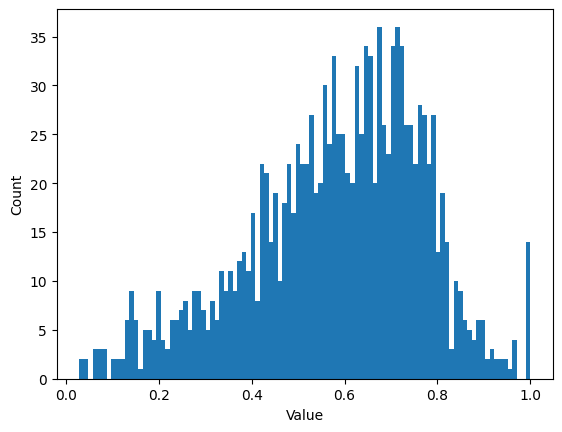

In [10]:
plt.hist(drugbank_similarities, bins=100)
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

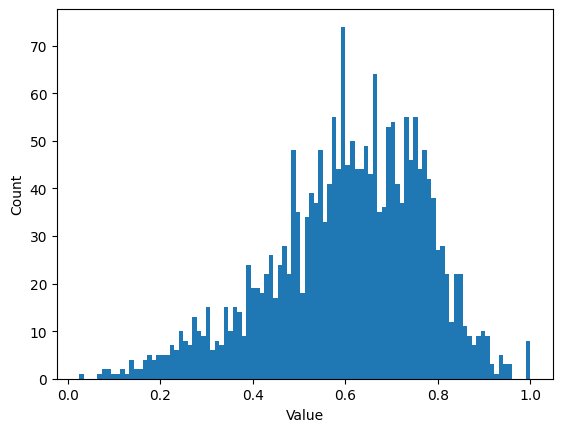

In [ ]:
plt.hist(metxbiodb_similarities, bins=100)
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

In [18]:
metx_argmin = np.argmax(metxbiodb_similarities)
np_metxbiodb_similarities = np.array(metxbiodb_similarities)
indices_less_than_03 = np.where(np_metxbiodb_similarities < 0.35)[0]
indices_greater_than_6 = np.where(np_metxbiodb_similarities > 0.65)[0]
#print(indices_less_than_03)
#print(indices_greater_than_6)
print(metxbiodb.iloc[7])
print(metxbiodb.iloc[5])

parent_name                             (R)-halothane
parent_smiles                         FC(F)(F)C(Cl)Br
metabolite_name                  trifluoroacetic acid
metabolite_smiles                      O=C(O)C(F)(F)F
enzymes                                        CYP2E1
reaction_type        Oxidation of halotrifluoroethane
Name: 7, dtype: object
parent_name           5-Methoxy-N,N-diisopropyltryptamine
parent_smiles        COC1=CC=C2NC=C(CCN(C(C)C)C(C)C)C2=C1
metabolite_name                                 5-OH-DIPT
metabolite_smiles     CC(C)N(CCC1=CNC2=CC=C(O)C=C12)C(C)C
enzymes                                            CYP2D6
reaction_type                             O-Demethylation
Name: 5, dtype: object


In [ ]:
def filter_out_data(drugbank_df, invalid_fingerprint_ids, invalid_enzyme_ids):
    orig_count = len(drugbank_df)
    drugbank_df = drugbank_df.drop(invalid_fingerprint_ids, inplace=True, errors='ignore')
    drugbank_df = drugbank_df.drop(invalid_enzyme_ids, inplace=True, errors='ignore')
    dropped_count = orig_count - len(drugbank_df)
    print("dropped: ",  dropped_count)
    return drugbank_df

In [159]:
enzymes = drugbank.dropna()
orig_count = len(enzymes)

# Go over the endogenous enzymes and drop those that match
for endogenous_enzyme in filtered_drugbank_enzymes:
    enzymes = enzymes[(enzymes['enzymes'] == '') | (enzymes['enzymes'] != endogenous_enzyme)]
        
print("dropped: ", orig_count -len(enzymes))

#drugbank_df = filter_out_data(drugbank,[],[])

dropped:  120
